In [345]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [346]:
train_raw=pd.read_csv("train.csv", index_col="Id")
print(train_raw.shape)

(1460, 80)


In [347]:
test_raw=pd.read_csv("test.csv", index_col="Id")
print(test_raw.shape)

(1459, 79)


In [348]:
df =pd.read_csv("train_test.csv", index_col="Id")
df.shape

(2919, 71)

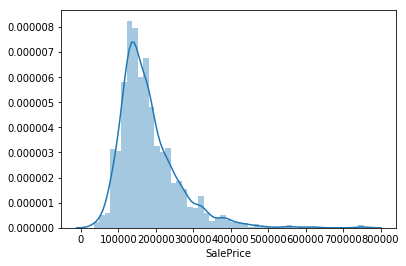

In [278]:
## Check Skewness of target value 
sns.distplot(train['SalePrice'])

In [349]:
df["SalePrice"]= np.log1p(df["SalePrice"])

In [ ]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## Missingness 

In [ ]:
#missing value counter
def na_counter(data):
    coln = list(data.columns)
    df_na ={}
    for col in coln:
        if data[col].isnull().any()==True:
            mvalue = data[col].isnull().sum()
            mpercent = data[col].isnull().sum()/len(data)
            df_na[col]=[mvalue, mpercent]
    df_Na =pd.DataFrame(df_na).T
    df_Na.columns = ['NA',"PERCENT"]
    return df_Na

In [ ]:
na_counter(train)

### 1. Pearson correlation -Univariate Features

In [350]:
## Split data in 2 
train, test = np.split(df,[1460])

In [351]:
corr = train.corr(method='pearson').drop(['SalePrice']).sort_values('SalePrice', ascending=False)['SalePrice']

In [352]:
df_corr = df.drop(['PoolArea','3SsnPorch','BsmtFinSF2'], axis=1)

In [136]:
#'OverallCond','MSSubClass' have also very low correlation, but these are ordinal features so these features were
# additionally check through chi sq test. 

In [353]:
df_corr.shape

(2919, 68)

In [354]:
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import norm, skew 

#get the numeric values
#numeric_features =df_corr.dtypes[df_corr.dtypes != "object"].index
#numeric_features

def numeric_col(data):
    numeric_features=[]
    coln = data.columns
    for col in coln :
        if len(data[col].value_counts()) >26 :
            numeric_features.append(col)
    return numeric_features

numeric_features = numeric_col(df_corr)

In [355]:
from sklearn import linear_model

In [356]:
scores = {}
lm = linear_model.LinearRegression()
from sklearn.metrics import r2_score
for feature_name in numeric_features:
    df_numeric = df_corr[numeric_features].copy()
    feature = df_corr[feature_name].copy()
    df_numeric.drop(feature_name, axis=1, inplace=True)
    lm.fit(df_numeric, feature)
    scores[feature_name] = lm.score(df_numeric, feature)  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

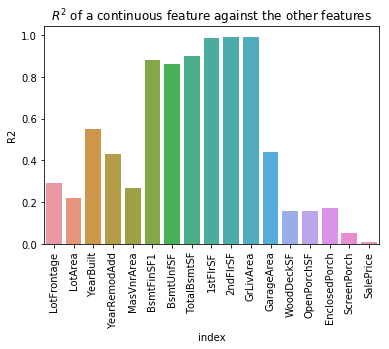

In [357]:
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features')
plt.xticks(rotation=90)

In [358]:
# Adding total sqfootage feature 
df_corr['TotalSF'] = df_corr['TotalBsmtSF'] + df_corr['1stFlrSF'] + df_corr['2ndFlrSF']

In [359]:
df_corr =  df_corr.drop([ '1stFlrSF', '2ndFlrSF','TotalBsmtSF'], axis=1)

In [360]:
# Check the skew of all numerical features
numeric_features = numeric_col(df_corr)
numeric_features

skewed_feats = df_corr[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})


Skew in numerical features: 



In [361]:
skewness = skewness[abs(skewness)>0.5]
df_corr[skewness.index] = np.log1p(df_corr[skewness.index])

In [362]:
# Check the skew of all numerical features
skewed_feats =df_corr[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
ScreenPorch,2.945905
EnclosedPorch,1.961081
MasVnrArea,0.537018
WoodDeckSF,0.158033
GrLivArea,0.013188
SalePrice,0.000171
OpenPorchSF,-0.041797
TotalSF,-0.368434
YearRemodAdd,-0.458157
LotArea,-0.504751


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A8C5FE9630>]],
      dtype=object)

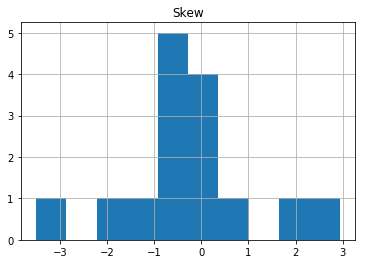

In [363]:
skewness.hist()

In [370]:
df['YrSold'].value_counts()

2007    692
2009    647
2008    622
2006    619
2010    339
Name: YrSold, dtype: int64

In [ ]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [144]:
bins = [-1, 160, 350, 620, 720,900, np.inf]
names = ['0', '300', '500',"700",'800',"1200" ]

df_corr["GarageArea"] = pd.cut(df_corr["GarageArea"], bins, labels=names)

In [364]:
bins = [0, 1950, 1960, 1970, 1980, 1990,2000, np.inf]
names = ['50', '51_60', '61_70','71_80','81_90','91_00','01_10']

df_corr["YearRemodAdd"] = pd.cut(df_corr["YearRemodAdd"], bins, labels=names)

In [146]:

bins = [-1, 18, 300, np.inf]
names = ['0', '1', '2']
df_corr["EnclosedPorch"] = pd.cut(df_corr["EnclosedPorch"], bins, labels=names)

In [147]:
bins = [-1, 39, 300, np.inf]
names = ['0', '1', '2']
df_corr["ScreenPorch"] = pd.cut(df_corr["ScreenPorch"], bins, labels=names)


In [ ]:
df.groupby(["ScreenPorch_R"]).size()

In [ ]:
len(df_corr.columns)

In [ ]:
from sklearn.preprocessing import minmax_scale

df['col_name']= minmax_scale(df['col_name'], axis=0, copy=True)

### 2. Chi sq Test - categorical features 

In [365]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency

def categorical_col(data):
    cat_col=[]
    coln = data.columns
    for col in coln :
        if len(data[col].value_counts()) <26 :
            cat_col.append(col)
    return cat_col

def ChiSquare(data, colY):
    cat_col=[]
    result = []
    
    coln = data.columns
    for col in coln :
        if len(data[col].value_counts()) <26 :
            cat_col.append(col)
    result = []
    
    for colX in cat_col:
        X = data[colX].astype(str)
        Y = data[colY].astype(str)
        dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
        dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
        
        if p<0.05:
            result.append(colX)
        
    return result


In [366]:
# list of features which were important 

chi_result_features = ChiSquare(train, "SalePrice")
df_corr_features = df_corr.columns

f_features = set(chi_result_features).union(set(df_corr_features))
f_features = list(f_features)
f_features.remove('SalePrice')

In [367]:
df_corr = df_corr[list(f_features)]

### Spearman Rank Corr

In [ ]:
from scipy.stats import spearmanr
def spearman(data, colY):
    Columns =  df_corr.describe().columns
    for col in Columns :
        corr, p_value = spearmanr(data[col], data[colY])
        print (print(" {} : corr {}, p_value {} \n".format(col, corr,p_value)))

### 3. Remove low variance features

In [ ]:
#variance_ = dict(zip(df_corr.columns, np.var(df_corr, 0)))
#sorted(variance_.items(), key=lambda x: x[1])

In [ ]:
#df_low_var=df.drop(['YearRemodAdd','RoofStyle','MasVnrArea','MasVnrType','Foundation','Exterior2nd', 'ExterCond','Exterior1st'], axis=1)
#df_low_var.shape

In [371]:
def make_dummies(data):
    cat_col=[]
    coln = data.columns
    for col in coln :
        if len(data[col].value_counts()) <26 :
            cat_col.append(col)
    return pd.get_dummies(data, columns=cat_col, drop_first=True)

In [372]:
df1 = make_dummies(df_corr)
df1.shape

(2919, 311)

In [373]:
df1.head()

,EnclosedPorch,ScreenPorch,OpenPorchSF,BsmtFinSF1,GarageArea,BsmtUnfSF,WoodDeckSF,LotArea,MasVnrArea,GrLivArea,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,FullBath_1,FullBath_2,FullBath_3,FullBath_4
Id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,4.127134,6.561031,6.308098,5.017280,0.000000,9.042040,5.283204,7.444833,...,0,0,0,0,0,1,0,1,0,0
2,0.000000,0.0,0.000000,6.886532,6.133398,5.652489,5.700444,9.169623,0.000000,7.141245,...,0,0,0,0,0,1,0,1,0,0
3,0.000000,0.0,3.761200,6.188264,6.411818,6.075346,0.000000,9.328212,5.093750,7.488294,...,0,0,0,0,0,1,0,1,0,0
4,5.609472,0.0,3.583519,5.379897,6.466145,6.293419,0.000000,9.164401,0.000000,7.448916,...,0,0,0,0,0,1,1,0,0,0
5,0.000000,0.0,4.442651,6.486161,6.729824,6.196444,5.262690,9.565284,5.860786,7.695758,...,0,0,0,0,0,1,0,1,0,0


### Model validation

In [374]:
y= np.log1p(train_raw["SalePrice"])

In [375]:
## Split data in 2 
X_train, test = np.split(df1,[1460])

In [376]:
test.shape

(1459, 311)

In [377]:
X = X_train.values
y_train = y.values

In [378]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [379]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
lm = linear_model.LinearRegression()
ridge = linear_model.Ridge(alpha=1)
lasso = linear_model.Lasso(alpha = 0.0005)
ENet = linear_model.ElasticNet(alpha = 1, l1_ratio = 0.5)
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

In [380]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [381]:
#define a rmsle evaluation function

def rmsle(y, y_pred): 
    return np.sqrt(mean_squared_error(y, y_pred))

#### linear_regression

In [382]:
lm.fit(X_train, y_train)
lm_train_pr = lm.predict(X_train)
lm_test_pr = np.expm1(lm.predict(test.values))
print(rmsle(y_train, lm_train_pr))

0.10537351079937367


C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in expm1
  This is separate from the ipykernel package so we can avoid doing imports until


In [383]:
score = rmsle_cv(lm)
print("\nLm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lm score: 8702911044.9508 (10043089948.3357)



In [384]:
lasso.fit(X_train, y_train)
lasso_train_pr = lasso.predict(X_train)
lasso_test_pr = np.expm1(lasso.predict(test.values))
print(rmsle(y_train, lasso_train_pr))

0.11167431944665636


In [385]:
score = rmsle_cv(lasso)
print("\nlasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


lasso score: 0.1257 (0.0188)



In [386]:
ridge.fit(X_train, y_train)
ridge_train_pr = ridge.predict(X_train)
ridge_test_pr = np.expm1(ridge.predict(test.values))
print(rmsle(y_train, ridge_train_pr))

0.09950408279874215


In [387]:
score = rmsle_cv(ridge)
print("\nridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ridge score: 0.1297 (0.0202)



In [388]:
EN = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [389]:
EN.fit(X_train,y_train)
ENet_train_pred = EN.predict(X_train)
ENet_pred = np.expm1(EN.predict(test.values))
print(rmsle(y_train, ENet_train_pred))

0.11009600761443682


In [390]:
score = rmsle_cv(EN)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1254 (0.0197)



In [391]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [392]:
score = rmsle_cv(GBoost)
print("GBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

GBoost score: 0.1235 (0.0184)



In [314]:
GBoost.fit(X_train,y_train)
GBoost_train_pred = GBoost.predict(X_train)
GBoost_pred = np.expm1(GBoost.predict(test.values))
print(rmsle(y_train, GBoost_train_pred))

0.05955167132719791


In [329]:
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

## Random forest

#### 1. Grid Search

In [338]:
randomForest =RandomForestRegressor()

In [339]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {'n_estimators': [3, 10, 30, 60, 90], 'max_features': [50,300]},
    {'bootstrap': [True], 'n_estimators': [3, 10, 30, 60, 90], 'max_features': [50,100,150,200,250]},
]
grid_search_forest = GridSearchCV(randomForest, param_grid , scoring='accuracy', cv=5, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Soo\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Soo\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001A8BD781300, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Soo\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\S...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001A8BD781300, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Soo\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\S...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    500         if self.poller is not None:
    501             self.poller.start()
    502         self.kernel.start()
    503         self.io_loop = ioloop.IOLoop.current()
    504         try:
--> 505             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    506         except KeyboardInterrupt:
    507             pass
    508 
    509 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
C:\Users\Soo\Anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    534         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    535                                finalizer=self._asyncgen_finalizer_hook)
    536         try:
    537             events._set_running_loop(self)
    538             while True:
--> 539                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    540                 if self._stopping:
    541                     break
    542         finally:
    543             self._stopping = False

...........................................................................
C:\Users\Soo\Anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1770                         logger.warning('Executing %s took %.3f seconds',
   1771                                        _format_handle(handle), dt)
   1772                 finally:
   1773                     self._current_handle = None
   1774             else:
-> 1775                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...328>, ...]))>))>>
   1776         handle = None  # Needed to break cycles when an exception occurs.
   1777 
   1778     def _set_coroutine_origin_tracking(self, enabled):
   1779         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
C:\Users\Soo\Anaconda3\lib\asyncio\events.py in _run(self=<Handle IOLoop._run_callback(functools.par...328>, ...]))>))>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_w...BA0270>, <zmq.sugar.fr...001A8BFBA0328>, ...]))>),)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_w...BA0270>, <zmq.sugar.fr...001A8BFBA0328>, ...]))>))
    753         """Runs a callback with error handling.
    754 
    755         For use in subclasses.
    756         """
    757         try:
--> 758             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_w...BA0270>, <zmq.sugar.fr...001A8BFBA0328>, ...]))>)
    759             if ret is not None:
    760                 from tornado import gen
    761                 # Functions that return Futures typically swallow all
    762                 # exceptions and store them in the Future.  If a Future

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<Future finished result=(10, 363, <bound method....FBA0270>, <zmq.sugar.fr...001A8BFBA0328>, ...]))>,), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<Future finished result=(10, 363, <bound method....FBA0270>, <zmq.sugar.fr...001A8BFBA0328>, ...]))>,)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\gen.py in inner(f=None)
   1228             return False
   1229         elif not self.future.done():
   1230             def inner(f):
   1231                 # Break a reference cycle to speed GC.
   1232                 f = None  # noqa
-> 1233                 self.run()
   1234             self.io_loop.add_future(
   1235                 self.future, inner)
   1236             return False
   1237         return True

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\gen.py in run(self=<tornado.gen.Runner object>)
   1142                         finally:
   1143                             # Break up a reference to itself
   1144                             # for faster GC on CPython.
   1145                             exc_info = None
   1146                     else:
-> 1147                         yielded = self.gen.send(value)
        yielded = undefined
        self.gen.send = <built-in method send of generator object>
        value = (10, 363, <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>, (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]))
   1148 
   1149                     if stack_context._state.contexts is not orig_stack_contexts:
   1150                         self.gen.throw(
   1151                             stack_context.StackContextInconsistentError(

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in process_one(self=<ipykernel.ipkernel.IPythonKernel object>, wait=True)
    352         else:
    353             try:
    354                 priority, t, dispatch, args = self.msg_queue.get_nowait()
    355             except QueueEmpty:
    356                 return None
--> 357         yield gen.maybe_future(dispatch(*args))
        dispatch = <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>
        args = (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    358 
    359     @gen.coroutine
    360     def dispatch_queue(self):
    361         """Coroutine to preserve order of message handling

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object Kernel.dispatch_shell>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 3, 7, 3, 2, 179749, tzinfo=tzutc()), 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'session': '9ca9305f56eb421bbee25ddc00dc24a5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'parent_header': {}})
    262             try:
    263                 self.pre_handler_hook()
    264             except Exception:
    265                 self.log.debug("Unable to signal in pre_handler_hook:", exc_info=True)
    266             try:
--> 267                 yield gen.maybe_future(handler(stream, idents, msg))
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'9ca9305f56eb421bbee25ddc00dc24a5']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 3, 7, 3, 2, 179749, tzinfo=tzutc()), 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'session': '9ca9305f56eb421bbee25ddc00dc24a5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'parent_header': {}}
    268             except Exception:
    269                 self.log.error("Exception in message handler:", exc_info=True)
    270             finally:
    271                 try:

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [b'9ca9305f56eb421bbee25ddc00dc24a5'], {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 3, 7, 3, 2, 179749, tzinfo=tzutc()), 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'session': '9ca9305f56eb421bbee25ddc00dc24a5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'parent_header': {}}), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object Kernel.execute_request>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'9ca9305f56eb421bbee25ddc00dc24a5'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 3, 3, 7, 3, 2, 179749, tzinfo=tzutc()), 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'session': '9ca9305f56eb421bbee25ddc00dc24a5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '73292689ed0a4b1784c557365c558219', 'msg_type': 'execute_request', 'parent_header': {}})
    529             self._publish_execute_input(code, parent, self.execution_count)
    530 
    531         reply_content = yield gen.maybe_future(
    532             self.do_execute(
    533                 code, silent, store_history,
--> 534                 user_expressions, allow_stdin,
        user_expressions = {}
        allow_stdin = True
    535             )
    536         )
    537 
    538         # Flush output before sending the reply.

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, 'from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', False, True, {}, True), **kwargs={})
    321                 # never actually yields, which in turn allows us to
    322                 # use "optional" coroutines in critical path code without
    323                 # performance penalty for the synchronous case.
    324                 try:
    325                     orig_stack_contexts = stack_context._state.contexts
--> 326                     yielded = next(result)
        yielded = undefined
        result = <generator object IPythonKernel.do_execute>
    327                     if stack_context._state.contexts is not orig_stack_contexts:
    328                         yielded = _create_future()
    329                         yielded.set_exception(
    330                             stack_context.StackContextInconsistentError(

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    289                     res = yield coro_future
    290             else:
    291                 # runner isn't already running,
    292                 # make synchronous call,
    293                 # letting shell dispatch to loop runners
--> 294                 res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        code = 'from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)'
        store_history = True
        silent = False
    295         finally:
    296             self._restore_input()
    297 
    298         if res.error_before_exec is not None:

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    531             )
    532         self.payload_manager.write_payload(payload)
    533 
    534     def run_cell(self, *args, **kwargs):
    535         self._last_traceback = None
--> 536         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    537 
    538     def _showtraceback(self, etype, evalue, stb):
    539         # try to preserve ordering of tracebacks and print statements
    540         sys.stdout.flush()

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2814         result : :class:`ExecutionResult`
   2815         """
   2816         result = None
   2817         try:
   2818             result = self._run_cell(
-> 2819                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)'
        store_history = True
        silent = False
        shell_futures = True
   2820         finally:
   2821             self.events.trigger('post_execute')
   2822             if not silent:
   2823                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2840             runner = self.loop_runner
   2841         else:
   2842             runner = _pseudo_sync_runner
   2843 
   2844         try:
-> 2845             return runner(coro)
        runner = <function _pseudo_sync_runner>
        coro = <generator object InteractiveShell.run_cell_async>
   2846         except BaseException as e:
   2847             info = ExecutionInfo(raw_cell, store_history, silent, shell_futures)
   2848             result = ExecutionResult(info)
   2849             result.error_in_exec = e

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\async_helpers.py in _pseudo_sync_runner(coro=<generator object InteractiveShell.run_cell_async>)
     62 
     63     Credit to Nathaniel Smith
     64 
     65     """
     66     try:
---> 67         coro.send(None)
        coro.send = <built-in method send of generator object>
     68     except StopIteration as exc:
     69         return exc.value
     70     else:
     71         # TODO: do not raise but return an execution result with the right info.

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell_async(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import GridSearchCV...1)\n%time grid_search_forest.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   3015                 interactivity = "none" if silent else self.ast_node_interactivity
   3016                 if _run_async:
   3017                     interactivity = 'async'
   3018 
   3019                 has_raised = yield from self.run_ast_nodes(code_ast.body, cell_name,
-> 3020                        interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   3021 
   3022                 self.last_execution_succeeded = not has_raised
   3023                 self.last_execution_result = result
   3024 

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-339-c0a3fa9f08ec>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1a8c5ece320, executio...rue silent=False shell_futures=True> result=None>)
   3186                         return True
   3187 
   3188                 for i, node in enumerate(to_run_interactive):
   3189                     mod = ast.Interactive([node])
   3190                     code = compiler(mod, cell_name, "single")
-> 3191                     if (yield from self.run_code(code, result)):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001A8C5A85A50, file "<ipython-input-339-c0a3fa9f08ec>", line 9>
        result = <ExecutionResult object at 1a8c5ece320, executio...rue silent=False shell_futures=True> result=None>
   3192                         return True
   3193 
   3194             # Flush softspace
   3195             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001A8C5A85A50, file "<ipython-input-339-c0a3fa9f08ec>", line 9>, result=<ExecutionResult object at 1a8c5ece320, executio...rue silent=False shell_futures=True> result=None>, async_=False)
   3262                 if async_:
   3263                     last_expr = (yield from self._async_exec(code_obj, self.user_ns))
   3264                     code = compile('last_expr', 'fake', "single")
   3265                     exec(code, {'last_expr': last_expr})
   3266                 else:
-> 3267                     exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001A8C5A85A50, file "<ipython-input-339-c0a3fa9f08ec>", line 9>
        self.user_global_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...}
        self.user_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...}
   3268             finally:
   3269                 # Reset our crash handler in place
   3270                 sys.excepthook = old_excepthook
   3271         except SystemExit as e:

...........................................................................
C:\Users\Soo\Desktop\nycdsa\project-ML\<ipython-input-339-c0a3fa9f08ec> in <module>()
      4 param_grid = [
      5     {'n_estimators': [3, 10, 30, 60, 90], 'max_features': [50,300]},
      6     {'bootstrap': [True], 'n_estimators': [3, 10, 30, 60, 90], 'max_features': [50,100,150,200,250]},
      7 ]
      8 grid_search_forest = GridSearchCV(randomForest, param_grid , scoring='accuracy', cv=5, n_jobs=-1)
----> 9 get_ipython().run_line_magic('time', 'grid_search_forest.fit(X_train, y_train)')

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_line_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='grid_search_forest.fit(X_train, y_train)', _stack_depth=1)
   2282             kwargs = {}
   2283             # Grab local namespace if we need it:
   2284             if getattr(fn, "needs_local_scope", False):
   2285                 kwargs['local_ns'] = sys._getframe(stack_depth).f_locals
   2286             with self.builtin_trap:
-> 2287                 result = fn(*args,**kwargs)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        args = ['grid_search_forest.fit(X_train, y_train)']
        kwargs = {'local_ns': {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...}}
   2288             return result
   2289 
   2290     def run_cell_magic(self, magic_name, line, cell):
   2291         """Execute the given cell magic.

...........................................................................
C:\Users\Soo\Desktop\nycdsa\project-ML\<decorator-gen-63> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='grid_search_forest.fit(X_train, y_train)', cell=None, local_ns={'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...})

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, 'grid_search_forest.fit(X_train, y_train)', None, {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...}), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, 'grid_search_forest.fit(X_train, y_train)', None, {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...})
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\IPython\core\magics\execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='grid_search_forest.fit(X_train, y_train)', cell=None, local_ns={'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...})
   1258         # time execution
   1259         wall_st = wtime()
   1260         if mode=='eval':
   1261             st = clock2()
   1262             try:
-> 1263                 out = eval(code, glob, local_ns)
        out = undefined
        code = <code object <module> at 0x000001A8C5A85930, file "<timed eval>", line 1>
        glob = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...}
        local_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'BayesianRidge': <class 'sklearn.linear_model.bayes.BayesianRidge'>, 'ChiSquare': <function ChiSquare>, 'EN': Pipeline(memory=None,
     steps=[('robustscaler...ection='cyclic', tol=0.0001, warm_start=False))]), 'ENet': ElasticNet(alpha=1, copy_X=True, fit_intercept=T...selection='cyclic', tol=0.0001, warm_start=False), 'ENet_pred': array([118935.01379472, 158826.45339201, 188379....0091.33536502, 123318.00754889, 222909.94956696]), 'ENet_train_pred': array([12.2308963 , 12.10861007, 12.29244228, ..., 12.45220974,
       11.84012015, 11.90302533]), 'ElasticNet': <class 'sklearn.linear_model.coordinate_descent.ElasticNet'>, 'GBR': GradientBoostingRegressor(alpha=0.9, criterion='...      subsample=1.0, verbose=0, warm_start=False), 'GBoost': GradientBoostingRegressor(alpha=0.9, criterion='...le=1.0, verbose=0,
             warm_start=False), ...}
   1264             except:
   1265                 self.shell.showtraceback()
   1266                 return
   1267             end = clock2()

...........................................................................
C:\Users\Soo\Desktop\nycdsa\project-ML\<timed eval> in <module>()

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...ore='warn',
       scoring='accuracy', verbose=0), X=      EnclosedPorch  ScreenPorch  OpenPorchSF  B...0  
1460           0  

[1460 rows x 288 columns], y=array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023]), groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=5, random_state=None, shuffle=False)>
        X =       EnclosedPorch  ScreenPorch  OpenPorchSF  B...0  
1460           0  

[1460 rows x 288 columns]
        y = array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Mar  3 02:03:07 2019
PID: 3712                   Python 3.7.2: C:\Users\Soo\Anaconda3\python.exe
...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False),       EnclosedPorch  ScreenPorch  OpenPorchSF  B...         0           0

[1460 rows x 288 columns], array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023]), {'score': make_scorer(accuracy_score)}, array([ 292,  293,  294, ..., 1457, 1458, 1459]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 284, 285,
       286, 287, 288, 289, 290, 291]), 0, {'max_features': 50, 'n_estimators': 3}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False),       EnclosedPorch  ScreenPorch  OpenPorchSF  B...         0           0

[1460 rows x 288 columns], array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023]), {'score': make_scorer(accuracy_score)}, array([ 292,  293,  294, ..., 1457, 1458, 1459]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 284, 285,
       286, 287, 288, 289, 290, 291]), 0, {'max_features': 50, 'n_estimators': 3})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=      EnclosedPorch  ScreenPorch  OpenPorchSF  B...         0           0

[1460 rows x 288 columns], y=array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023]), scorer={'score': make_scorer(accuracy_score)}, train=array([ 292,  293,  294, ..., 1457, 1458, 1459]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 284, 285,
       286, 287, 288, 289, 290, 291]), verbose=0, parameters={'max_features': 50, 'n_estimators': 3}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False)
        X_test =      EnclosedPorch  ScreenPorch  OpenPorchSF  Bs...          0           0

[292 rows x 288 columns]
        y_test = array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196])
        scorer = {'score': make_scorer(accuracy_score)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X_test=     EnclosedPorch  ScreenPorch  OpenPorchSF  Bs...          0           0

[292 rows x 288 columns], y_test=array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196]), scorer={'score': make_scorer(accuracy_score)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False)
        X_test =      EnclosedPorch  ScreenPorch  OpenPorchSF  Bs...          0           0

[292 rows x 288 columns]
        y_test = array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196])
        scorer = {'score': make_scorer(accuracy_score)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X_test=     EnclosedPorch  ScreenPorch  OpenPorchSF  Bs...          0           0

[292 rows x 288 columns], y_test=array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196]), scorers={'score': make_scorer(accuracy_score)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(accuracy_score)
        estimator = RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False)
        X_test =      EnclosedPorch  ScreenPorch  OpenPorchSF  Bs...          0           0

[292 rows x 288 columns]
        y_test = array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(accuracy_score), estimator=RandomForestRegressor(bootstrap=True, criterion=...ate=None,
           verbose=0, warm_start=False), X=     EnclosedPorch  ScreenPorch  OpenPorchSF  Bs...          0           0

[292 rows x 288 columns], y_true=array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196]), sample_weight=None)
    103             return self._sign * self._score_func(y_true, y_pred,
    104                                                  sample_weight=sample_weight,
    105                                                  **self._kwargs)
    106         else:
    107             return self._sign * self._score_func(y_true, y_pred,
--> 108                                                  **self._kwargs)
        self._kwargs = {}
    109 
    110 
    111 class _ProbaScorer(_BaseScorer):
    112     def __call__(self, clf, X, y, sample_weight=None):

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py in accuracy_score(y_true=array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196]), y_pred=array([12.26779563, 12.05846903, 12.19265134, 12...4, 11.86373187,
       12.40567772, 12.07610943]), normalize=True, sample_weight=None)
    171     >>> accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))
    172     0.5
    173     """
    174 
    175     # Compute accuracy for each possible representation
--> 176     y_type, y_true, y_pred = _check_targets(y_true, y_pred)
        y_type = undefined
        y_true = array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196])
        y_pred = array([12.26779563, 12.05846903, 12.19265134, 12...4, 11.86373187,
       12.40567772, 12.07610943])
    177     if y_type.startswith('multilabel'):
    178         differing_labels = count_nonzero(y_true - y_pred, axis=1)
    179         score = differing_labels == 0
    180     else:

...........................................................................
C:\Users\Soo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py in _check_targets(y_true=array([12.24769912, 12.10901644, 12.31717117, 11...2, 11.94195084,
       12.35978466, 11.81968196]), y_pred=array([12.26779563, 12.05846903, 12.19265134, 12...4, 11.86373187,
       12.40567772, 12.07610943]))
     83     # We can't have more than one value on y_type => The set is no more needed
     84     y_type = y_type.pop()
     85 
     86     # No metrics support "multiclass-multioutput" format
     87     if (y_type not in ["binary", "multiclass", "multilabel-indicator"]):
---> 88         raise ValueError("{0} is not supported".format(y_type))
        y_type = 'continuous'
     89 
     90     if y_type in ["binary", "multiclass"]:
     91         y_true = column_or_1d(y_true)
     92         y_pred = column_or_1d(y_pred)

ValueError: continuous is not supported
___________________________________________________________________________

In [340]:
rf_random.best_params_

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 60, 90], 'max_features': [50, 300]}, {'bootstrap': [True], 'n_estimators': [3, 10, 30, 60, 90], 'max_features': [50, 100, 150, 200, 250]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [ ]:
## best score
grid_search_tree.best_score_

In [ ]:
## The overall accuracy on the test set:
grid_search_tree.score(x_test, y_test)

#### 2. RandomForest

In [ ]:
grid_search.best_estimator_

In [316]:
regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [317]:
score = rmsle_cv(regr)
print("regr score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

regr score: 0.1453 (0.0183)



In [318]:
regr.fit(X_train,y_train)
regr_train_pred = regr.predict(X_train)
regr_pred = np.expm1(regr.predict(test.values))
print(rmsle(y_train, regr_train_pred))

0.05534900315146857


In [ ]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
model = RandomForestRegressor(n_jobs=1,criterion='mse')

In [268]:
score = rmsle_cv(GBR)
print("gbr score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

gbr score: 0.1304 (0.0135)



In [267]:
### GBR
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)

In [393]:
import xgboost as xgb
import lightgbm as lgb

ModuleNotFoundError: No module named 'xgboost'

In [394]:
ensemble = ENet_pred*0.5 + GBoost_pred*0.5

## Submission

In [395]:
predictions = ensemble

print(predictions.shape)
predictions

(1459,)


array([122203.30568533, 160943.11893134, 190158.28552787, ...,
       174520.42811724, 120893.53634424, 212182.69864127])

In [396]:
submission = pd.read_csv("sample_submission.csv")
print(submission.shape)
submission.head()

(1459, 2)


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [397]:
submission["SalePrice"] = predictions
submission.head()


,Id,SalePrice
0,1461,122203.305685
1,1462,160943.118931
2,1463,190158.285528
3,1464,200209.741122
4,1465,195587.560890


In [398]:
submission.to_csv("housemodel_ens_2.csv", index=False)

In [262]:
### stacking models :
mlxtend.classfier import StackingClassifier


SyntaxError: invalid syntax (<ipython-input-262-c6d7424714ef>, line 2)